## This code uses deep DMD on data generated by making several random load changes for model identification:

Author: Sai Pushpak Nandanoori \
Organization: PNNL \
Date created: December 02, 2020 \

### Basic overview of the deepDMD implementation: 
Original time-series data labeled as: $\begin{bmatrix} x_1 & x_2 & x_3 & \dots & x_{n-1} & x_n \end{bmatrix}$ \
Create the following datasets from the given time-series data:\
$Y_p = \begin{bmatrix} x_1 & x_2 & x_3 & \dots & x_{n-1} \end{bmatrix}$ \
$Y_f = \begin{bmatrix} x_2 & x_3 & \dots & x_{n-1} & x_n \end{bmatrix}$

The time-series data is translated and approapriately scaled. \
Nonlinear observables - given by the encoder - $\psi$ \
State-inclusive observables (linear observables + learnt nonlinear observables) - $\Psi$ \
such that \
$\Psi(x) = \begin{bmatrix} x \\ \psi(x) \end{bmatrix}$ \
One time-step loss: $||\Psi(Y_f) - \mathcal{K} \Psi(Y_p)||_F^2$ \
where $\mathcal{K}$ is the Koopman operator. \
Observed that multi time-step loss is not needed. \ 

To avoid overfitting - weight regularization, dropout are added \
To deal with noisy measurements, regularization on the Koopman operator is implemented \
To deal with lack of data, time-delay embedding of the data is implemented by defining a window size and shift size

### Initial packages declaration and loading the functions needed

In [1]:
import helper_fcns
# import Koopman_helper_fcns
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import scipy
import math 
import sklearn
from scipy.linalg import block_diag
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from time import process_time

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

# Create Directory for model output
dir_name = 'trained_deepDMD_model'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    print("Directory '% s' created" % dir_name)

[INFO] Tensorflow version:  2.4.1
[INFO] Eager mode:  True


In [2]:
# !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -ofs 12 -mathfs 100 -N -kl -cursw 5 -cursc r -cellw 95% -T
# !jt -r

### Load the data corresponding to several scenarios. The entire data is stored in a single dictionary and each scenario data can be obtained by choosing the key value as the scenario number.

In [3]:
tic = process_time()
scenario_dir = '../../Data/Train'
# print('[INFO]: Loading the datasets from the directory:', scenario_dir)
dir_list = os.listdir(scenario_dir)
# Indicate the scenario range
Dataset = dict()
print('[INFO]: Loading data for %d scenarios ...' % len(dir_list))
l_start = process_time()
scenario_data = []
count = 0
for s_dir in dir_list:
    if s_dir.find('scenario') == -1:
        continue
    dataset = helper_fcns.TransientDataset('/%s/%s/' % (scenario_dir, s_dir))
    original_shape = np.concatenate((dataset.F, dataset.Vm), axis=1).shape
    scenario_data.append(np.concatenate((dataset.F[:1000,:], dataset.Vm[:1000,:]), axis=1))
    count += 1
    if count % 50 == 0:
        print('[INFO]: Loaded %d/%d scenarios ...' % (count, len(dir_list)))
l_stop = process_time()
print('[INFO]: Time taken for loading datasets:', l_stop - l_start, 'seconds')
print('[INFO]: Total number of scenarios loaded:', len(scenario_data))
print('[INFO]: Shape of each scenario original: ', original_shape)
print('[INFO]: Shape of each scenario loaded: ', scenario_data[0].shape)
print('[INFO]: Done ...')

[INFO]: Loading data for 30 scenarios ...
[INFO]: Time taken for loading datasets: 4.909953 seconds
[INFO]: Total number of scenarios loaded: 30
[INFO]: Shape of each scenario original:  (1400, 136)
[INFO]: Shape of each scenario loaded:  (1000, 136)
[INFO]: Done ...


In [4]:
i_start = process_time()
X_data = [] # Original data
Y_data = [] # 1 time-shifted data
U_data = [] # 2 time-shifted data
V_data = [] # 3 time-shifted data
whole_data = [] # Complete data 
Yp = [] # For analytical calculations
Yf = [] # For analytical calculations
count  = 0
ds  = 1
M = 2 # signifies number of time-shifts
N = 3 # signifies number of time-shifts

for dataset in scenario_data:    
    dataset_size = dataset.shape[0]
    whole_data.append(dataset)      
    Yp.append(dataset[:-1,:])
    Yf.append(dataset[1:,:])
    count += 1
    if count % 50 == 0:
        print('Done processing %d/%d datasets ...' % (count, len(scenario_data)))
    window_size = 800 # length of moving window
    shift_size  = 10 # separation between two moving windows
    i = 0
    while (i*shift_size+window_size+M+N) <= dataset_size:
        X_indices = range(i*shift_size, i*shift_size + window_size,ds)        
        Y_indices = range(i*shift_size+1, i*shift_size + window_size+1,ds)               
        U_indices = range(i*shift_size+M, i*shift_size + window_size+M,ds)               
        V_indices = range(i*shift_size+N, i*shift_size + window_size+N,ds)   
        if count < 0:
            print(X_indices)
            print(Y_indices)
            print(U_indices)
            print(V_indices)        

        i = i + 1
        X_data.append(dataset[X_indices])
        Y_data.append(dataset[Y_indices])
        U_data.append(dataset[U_indices])
        V_data.append(dataset[V_indices])

i_stop = process_time()
print('[INFO]: Time taken for creating X datasets:', i_stop - i_start, 'seconds')
print('[INFO]: Original dataset size:', dataset_size)
print('[INFO]: Chosen dataset size:', window_size)
print('[INFO]: Length of X_data: ', len(X_data))
print('[INFO]: Length of each window after down sampling: ', X_data[0].shape)

[INFO]: Time taken for creating X datasets: 1.0633269999999992 seconds
[INFO]: Original dataset size: 1000
[INFO]: Chosen dataset size: 800
[INFO]: Length of X_data:  600
[INFO]: Length of each window after down sampling:  (800, 136)


In [5]:
n_start = process_time()
Normalization = 1
scale_factor = 2*np.pi 

X_array = np.asarray(X_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Y_array = np.asarray(Y_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
U_array = np.asarray(U_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
V_array = np.asarray(V_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
whole_data_array = np.asarray(whole_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yp_array = np.asarray(Yp).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yf_array = np.asarray(Yf).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
print("[INFO]: whole_data_array shape:", whole_data_array.shape)
print('[INFO]: Yp_array shape: ', Yp_array.shape)
print('[INFO]: Yf_array shape: ', Yf_array.shape)
print('[INFO]: X_array shape: ', X_array.shape)
print('[INFO]: Y_array shape: ', Y_array.shape)
print('[INFO]: U_array shape: ', U_array.shape)
print('[INFO]: V_array shape: ', V_array.shape)

if Normalization:  
    X_array_old  = X_array
    Y_array_old  = Y_array
    U_array_old  = U_array
    V_array_old  = V_array
    Yp_array_old = Yp_array
    Yf_array_old = Yf_array
    X_array      = np.concatenate((scale_factor*(X_array_old[:,:68] - 60), 10*(X_array_old[:,68:] - 1)), axis = 1) 
    Y_array      = np.concatenate((scale_factor*(Y_array_old[:,:68] - 60), 10*(Y_array_old[:,68:] - 1)), axis = 1) 
    U_array      = np.concatenate((scale_factor*(U_array_old[:,:68] - 60), 10*(U_array_old[:,68:] - 1)), axis = 1) 
    V_array      = np.concatenate((scale_factor*(V_array_old[:,:68] - 60), 10*(V_array_old[:,68:] - 1)), axis = 1) 
    Yp_array     = np.concatenate((scale_factor*(Yp_array_old[:,:68] - 60), 10*(Yp_array_old[:,68:] - 1)), axis = 1)
    Yf_array     = np.concatenate((scale_factor*(Yf_array_old[:,:68] - 60), 10*(Yf_array_old[:,68:] - 1)), axis = 1)    
        
n_stop = process_time()
print('[INFO]: Time taken for normalization:', n_stop - n_start, 'seconds')

[INFO]: whole_data_array shape: (30000, 136)
[INFO]: Yp_array shape:  (29970, 136)
[INFO]: Yf_array shape:  (29970, 136)
[INFO]: X_array shape:  (480000, 136)
[INFO]: Y_array shape:  (480000, 136)
[INFO]: U_array shape:  (480000, 136)
[INFO]: V_array shape:  (480000, 136)
[INFO]: Time taken for normalization: 5.556713 seconds


(136,)


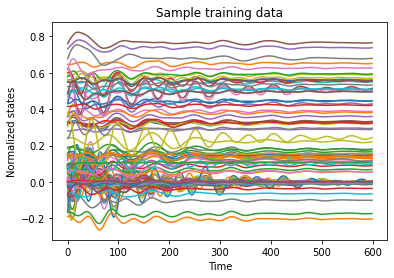

In [6]:
print(X_array[0].shape)
plt.plot(np.arange(0,600), X_array[:600,:])
plt.xlabel('Time')
plt.ylabel('Normalized states')
plt.title('Sample training data')
plt.savefig(dir_name+'/Normalized_States_Plot.Png')
plt.show()


### Define the dense layer and initialize it based on the Xavier initialization. This layer is used in the encoder as a dense layer (except for the last layer). 
- using the 'elu' activation function (noticed that 'tanh' has the similar performance)
- Keeping all the datatypes to 'float64'

In [7]:
class DenseLayer(layers.Layer):

    def __init__(self, units,input_dim,weights_regularizer,bias_regularizer):
        super(DenseLayer, self).__init__(dtype = 'float64')
        self.w = self.add_weight(shape = (input_dim, units), 
                                 initializer = tf.keras.initializers.RandomUniform(
                                     minval=-tf.cast(tf.math.sqrt(6.0/(input_dim+units)), dtype = 'float64'),  
                                     maxval=tf.cast(tf.math.sqrt(6.0/(input_dim+units)) , dtype = 'float64'),  
                                     seed=16751), 
                                 regularizer = tf.keras.regularizers.l1(weights_regularizer), 
                                 trainable = True)
        self.b = self.add_weight(shape = (units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        return tf.nn.elu(x)

### Define the linear layer and initialize it based on the Xavier initialization.  This layer is used in the encoder as a last layer. 

In [8]:
class LinearLayer(layers.Layer):

    def __init__(self, units,input_dim,weights_regularizer,bias_regularizer):
        super(LinearLayer, self).__init__(dtype = 'float64')
        self.w = self.add_weight(shape = (input_dim, units), 
                                 initializer = tf.keras.initializers.RandomUniform(
                                     minval=-tf.cast(tf.math.sqrt(6/(input_dim+units)), dtype = 'float64'), 
                                     maxval=tf.cast(tf.math.sqrt(6/(input_dim+units)), dtype = 'float64'), 
                                     seed=16751),                                                                   
#                                  regularizer = tf.keras.regularizers.l1(weights_regularizer), 
                                 trainable = True)
        self.b = self.add_weight(shape = (units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

### Define the nonlinear observables as a encoder
- Only drawback here is to manually define the number of layers need to be used in the encoder. 

In [9]:
# Neural Network
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hps):
        super(Encoder, self).__init__(dtype = 'float64', name = 'Encoder')
        self.input_layer   = DenseLayer(hps.h1, hps.od, 0.0, 0.0)
        self.hidden_layer1 = DenseLayer(hps.h2, hps.h1, hps.wr, hps.br)
        self.dropout_laye1 = layers.Dropout(hps.dr)
        self.hidden_layer2 = DenseLayer(hps.h3, hps.h2, hps.wr, hps.br)        
        self.dropout_laye2 = layers.Dropout(hps.dr)
        self.hidden_layer3 = DenseLayer(hps.h4, hps.h3, hps.wr, hps.br)
        self.dropout_laye3 = layers.Dropout(hps.dr)           
#         self.hidden_layer4 = DenseLayer(hps.h5, hps.h4, hps.wr, hps.br)
#         self.dropout_laye4 = layers.Dropout(hps.dr)             
        self.output_layer  = LinearLayer(hps.ld, hps.h4, hps.wr, hps.br)
        
    def call(self, input_data, training):
        fx = self.input_layer(input_data)        
        fx = self.hidden_layer1(fx)
        if training:
            fx = self.dropout_laye1(fx)     
        fx = self.hidden_layer2(fx)
        if training:
            fx = self.dropout_laye2(fx) 
        fx = self.hidden_layer3(fx)
        if training:
            fx = self.dropout_laye3(fx) 
#         fx = self.hidden_layer4(fx)
#         if training:
#             fx = self.dropout_laye4(fx)
        return self.output_layer(fx)    

### Complete Neural Network with the encoder, state-inclusive observables and the 1 time-step loss for Koopman

In [10]:
class NeuralNetworkModel(tf.keras.Model): 
    def __init__(self,hp):
        super(NeuralNetworkModel, self).__init__()
        self.EN = Encoder(hp)        
        # Define and randomly initialize the Koopman operator
        self.KO = tf.Variable(tf.random.normal(shape = (hp.ld+hp.od, hp.ld+hp.od), mean=0.0, stddev=0.05, 
                                                    dtype=tf.dtypes.float64, seed=123321, name='KoopmanOperator'),
                                                    trainable=True)
        self.rf = hp.rf 
        
    def call(self, inputs):       
        X        = inputs[0]
        Y        = inputs[1]                  
        
        Psi_X    = self.EN(X)
        Psi_Y    = self.EN(Y)        
        
        PSI_X    = tf.concat([X, Psi_X], 1)
        PSI_Y    = tf.concat([Y, Psi_Y], 1) 
        
        # 1-time step evolution on observable space:
        K_PSI_X  = tf.matmul(PSI_X, self.KO) 
        
        # 1-step Koopman loss on observable space:        
        K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

        # Regularization loss on Koopman operator:
        Reg_loss= tf.cast(tf.math.scalar_mul(self.rf,tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        
        
        # Total loss:
        loss = K_loss + Reg_loss 
        self.add_loss(loss)
        return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss

### List all the hyperparameters 
- All the hyperparameters are passed onto a class for easier passing

In [11]:
# Hyperparameters
original_dim       = 136   # input data dimension
hl_1_dim           = 128   # Hidden layer dimension
hl_2_dim           = 128   # Hidden layer dimension
hl_3_dim           = 64   # Hidden layer dimension
hl_4_dim           = 64   # Hidden layer dimension
# hl_5_dim           = 64   # Hidden layer dimension
latent_dim         = 64 # Latent space dimension 
reg_factor         = 0.01 # regularization weight for Koopman
dropout_prob       = 0.005  # dropout rate [regularization between hidden layers]
weight_regularizer = 0.001  # [L1] regularization weight for dense layer weights 
bias_regularizer   = 0    # [L1] regularization bias for dense layer biases
num_epochs         = 250  # Number of epochs 
learning_rate      = 5e-4 # learning rate for optimizer 
validation_split   = 0.25
batch_size         = 32

class HyperParameters:
    pass

hp = HyperParameters()
hp.od = original_dim
hp.h1 = hl_1_dim
hp.h2 = hl_2_dim
hp.h3 = hl_3_dim
hp.h4 = hl_4_dim
# hp.h5 = hl_5_dim
hp.ld = latent_dim
hp.rf = reg_factor
hp.dr = dropout_prob
hp.wr = weight_regularizer
hp.br = bias_regularizer
hp.ep = num_epochs
hp.lr = learning_rate
hp.bs = batch_size
hp.vs = validation_split

### Define the stopping criteria, optimization solver and fit the model for the given data. 

In [12]:
# Stopping criteria if the training loss doesn't go down by 1e-3
CallBack = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)
K_model = NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))
history = K_model.fit([X_array, Y_array], validation_split = hp.vs, batch_size = hp.bs, 
                   epochs=hp.ep, callbacks=[CallBack], shuffle = True)

Epoch 1/250
11250/11250 [==============================] - 21s 2ms/step - loss: 4.7460 - val_loss: 2.5743
Epoch 2/250
11250/11250 [==============================] - 21s 2ms/step - loss: 2.8048 - val_loss: 2.3795
Epoch 3/250
11250/11250 [==============================] - 36s 3ms/step - loss: 2.5445 - val_loss: 2.2484
Epoch 4/250
11250/11250 [==============================] - 31s 3ms/step - loss: 2.3823 - val_loss: 2.1420
Epoch 5/250
11250/11250 [==============================] - 21s 2ms/step - loss: 2.2547 - val_loss: 2.0457
Epoch 6/250
11250/11250 [==============================] - 24s 2ms/step - loss: 2.1443 - val_loss: 1.9598
Epoch 7/250
11250/11250 [==============================] - 24s 2ms/step - loss: 2.0480 - val_loss: 1.8796
Epoch 8/250
11250/11250 [==============================] - 23s 2ms/step - loss: 1.9613 - val_loss: 1.8071
Epoch 9/250
11250/11250 [==============================] - 23s 2ms/step - loss: 1.8821 - val_loss: 1.7415
Epoch 10/250
11250/11250 [====================

In [13]:
# Summarize the Koopman model:
K_model.summary()

Model: "neural_network_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Encoder)            multiple                  50624     
Total params: 90,624
Trainable params: 90,624
Non-trainable params: 0
_________________________________________________________________


### Monitoring the training and validation loss of the deepDMD model, checking the Koopman loss

Koopman loss: 2.5484
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


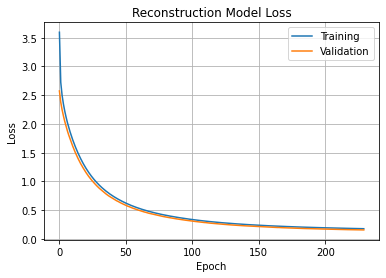

In [14]:
Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model([Yp_array, Yf_array], training=False)
print("Koopman loss: %.4f" %Kloss.numpy())

print('Psi_X shape:', Psi_X.numpy().shape)
print('Psi_Y shape:', Psi_Y.numpy().shape)
print('PSI_X shape:', PSI_X.numpy().shape)
print('PSI_X shape:', PSI_Y.numpy().shape)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Reconstruction Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(True)
plt.savefig(dir_name+'/Training_vs_Validation_Plot.Png')
plt.show()

### Find the Koopman operator and check its eigenvalues and sparsity structure 

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 8.480969332863118
[INFO]: Trace of K_deepDMD: 17.717066724013733
[INFO]: One time-step error with K_deepDMD: 2.548356826979319
[Output] Largest 10 eigenvalues of the Koopman operator
------------------------------
[1.     0.9945 0.9945 0.9897 0.9884 0.9884 0.9812 0.9804 0.9804 0.979 ]


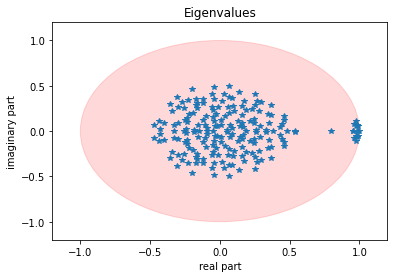

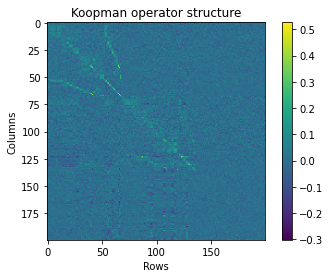

In [15]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK,eigenvectorsK] = np.linalg.eig(K_deepDMD)
abs_eigenvaluesK = np.absolute(eigenvaluesK)#.tolist()
abs_eigenvaluesK_sorted = np.sort(abs_eigenvaluesK)[::-1]
idx_eigenvaluesK_sorted = np.argsort(abs_eigenvaluesK)[::-1]
largest_n_eigenvalues = 10
print('[Output] Largest', largest_n_eigenvalues, 'eigenvalues of the Koopman operator')
print('------------------------------')
print(np.around(abs_eigenvaluesK_sorted[0:largest_n_eigenvalues], decimals = 4))

plt.plot(eigenvaluesK.real, eigenvaluesK.imag, '*')
plt.axis([-1.2, 1.2, -1.2, 1.2])
circle_plot = plt.Circle((0,0),1,alpha=0.15,color = 'r', fill=True)
plt.gcf().gca().add_artist(circle_plot)
# ax.set_aspect('equal')
plt.title('Eigenvalues')
plt.ylabel('imaginary part')
plt.xlabel('real part')
plt.savefig(dir_name+'/Eigenvalues.Png')
plt.show()

fig = plt.figure()
cs = plt.imshow(K_deepDMD)
plt.title('Koopman operator structure')
plt.xlabel('Rows')
plt.ylabel('Columns')
fig.colorbar(cs)
plt.savefig(dir_name+'/Koopman_Operator_Structure.Png')
plt.show()

### Get the neural network weights
- These weights are obtained after adding weight regularization. One can compare these weights with the neural network weights without any weight regularization. We can clearly see sparse structure here. 

11
(128, 128)


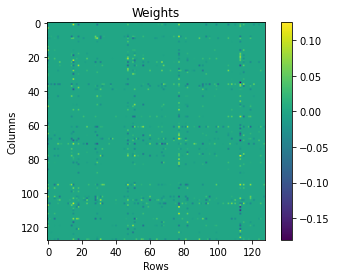

In [16]:
weights = K_model.get_weights()
print(len(weights))
print(weights[2].shape)
fig = plt.figure()
cs = plt.imshow(weights[2])
plt.title('Weights')
plt.xlabel('Rows')
plt.ylabel('Columns')
fig.colorbar(cs)
plt.savefig(dir_name+'/Neural_Network_Weights.Png')
plt.show()

### Consider a test scenario and check the predictions

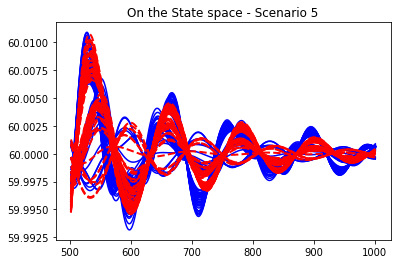

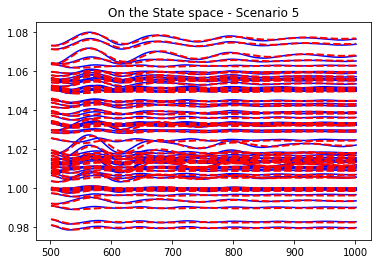

In [17]:
test_scen = 5
mat_file_data = sio.loadmat('../../Data/Test/Scenario'+ str(test_scen) +'/PMUData')
o_f_data  = mat_file_data['PMU']['f'][0][0]
o_Vm_data = mat_file_data['PMU']['Vm'][0][0]
f_data  = scale_factor*(o_f_data-60)
Vm_data = 10*(o_Vm_data - 1)

# Prediction using only one intitial condition:
start_point = 501
end_point   = start_point+1
X0 = np.concatenate((f_data[range(start_point,end_point)], Vm_data[range(start_point,end_point)]), axis = 1)

nts = 500
Psi_X, PSI_X, Psi_X, PSI_X, Kloss = K_model([X0, X0], training=False)

X_pred = np.zeros((nts, hp.ld+hp.od))
X_pred[0,:] = PSI_X

for k in range(nts-1):
    X_pred[k+1, :] = np.matmul(X_pred[k, :], K_deepDMD)

data_window = range(end_point,end_point+ds*nts,ds)
plt.plot(data_window,o_f_data[range(end_point,end_point+nts)],'b')
plt.plot(data_window,60+(1/scale_factor)*X_pred[:,:68],'r--',linewidth = 2)
plt.title('On the State space - Scenario ' + str(test_scen))
plt.savefig(dir_name+'/On the State space - Scenario ' + str(test_scen)+'IMG_1.png')
plt.show()

plt.plot(data_window,o_Vm_data[range(end_point,end_point+nts)],'b')
plt.plot(data_window,1+0.1*X_pred[:,68:136],'r--',linewidth = 2)
plt.title('On the State space - Scenario ' + str(test_scen))
plt.savefig(dir_name+'/On the State space - Scenario ' + str(test_scen)+'IMG_2.png')
plt.show()

### Predict using the obtained deepDMD model for all the testing scenarios and save the actual, predictions for all the scenarios into corresponding .mat files 

### Saving the neural network hyperparameters and the weights, Koopman operator for using in the surrogate model applications. 

In [19]:
# Get Encoder weights and biases:
# weights = K_model.get_weights()
sio.savemat(dir_name + "/Robust_deepDMD.mat",{"Weights":weights, "K": K_deepDMD, "HyperParameters":hp})

/Users/nand311/opt/anaconda3/envs/mytf2/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Calculating the time taken for the entire code to run

In [20]:
toc = process_time()
elapsed_time_sec = toc-tic
elapsed_time_min = np.floor(elapsed_time_sec/60)
remaining_sec = np.around(elapsed_time_sec - elapsed_time_min*60, decimals = 1)
   
print("Elapsed time:", elapsed_time_min, "minutes and", remaining_sec, "seconds")

Elapsed time: 281.0 minutes and 49.3 seconds
